
# Lasso模型选择:交叉验证 / AIC / BIC

>翻译者:[@Loopy](https://github.com/loopyme)        
>校验者:[@barrycg](https://github.com/barrycg)

本示例利用Akaike信息判据(AIC)、Bayes信息判据(BIC)和交叉验证，来筛选Lasso回归的正则化项参数alpha的最优值。

通过LassoLarsIC得到的结果，是基于AIC/BIC判据的。

 这种基于信息判据(AIC/BIC)的模型选择非常快，但它依赖于对自由度的正确估计。该方式的假设模型必需是正确, 而且是对大样本(渐近结果)进行推导，即，数据实际上是由该模型生成的。当问题的背景条件很差时(特征数大于样本数)，该模型选择方式会崩溃。

对于交叉验证，我们使用20-fold的2种算法来计算Lasso路径:LassoCV类实现的坐标下降和LassoLarsCV类实现的最小角度回归(Lars)。这两种算法给出的结果大致相同,但它们在执行速度和数值误差来源方面有所不同。

Lars仅为路径中的每个拐点计算路径解决方案。因此，当只有很少的弯折时，也就是很少的特征或样本时，它是非常有效的。此外，它能够计算完整的路径，而不需要设置任何元参数。与之相反，坐标下降算法计算预先指定的网格上的路径点(本示例中我们使用缺省值)。因此，如果网格点的数量小于路径中的拐点的数量，则效率更高。如果特征数量非常大，并且有足够的样本来选择大量特征，那么这种策略就非常有趣。在数值误差方面，Lars会因变量间的高相关度而积累更多的误差，而坐标下降算法只会采样网格上路径。

注意观察alpha的最优值是如何随着每个fold而变化。这是为什么当估交叉验证选择参数的方法的性能时，需要使用嵌套交叉验证的原因:这种参数的选择对于不可见数据可能不是最优的。


In [ ]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets

In [ ]:
# 这样做是为了避免在np.log10时除零
EPSILON = 1e-4

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

rng = np.random.RandomState(42)
X = np.c_[X, rng.randn(X.shape[0], 14)]  # 添加一些不好的特征

In [ ]:
# 将最小角度回归得到的数据标准化，以便进行比较
X /= np.sqrt(np.sum(X ** 2, axis=0))

In [ ]:
# LassoLarsIC: 用BIC/AIC判据进行最小角度回归

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_

In [ ]:
def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_ + EPSILON
    alphas_ = model.alphas_ + EPSILON
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s 判据' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s 估计' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('判据')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('模型选择的信息判据 (训练时间:%.3fs)'
          % t_bic)





    Text(0.5, 1.0, '模型选择的信息判据 (训练时间:0.024s)')




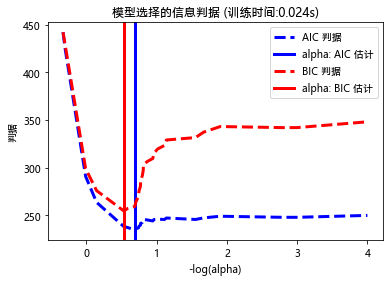



In [ ]:
# LassoCV: 坐标下降

# 计算路径
t1 = time.time()
model = LassoCV(cv=20).fit(X, y)
t_lasso_cv = time.time() - t1

# 显示结果
m_log_alphas = -np.log10(model.alphas_ + EPSILON)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='平均', linewidth=2)
plt.axvline(-np.log10(model.alpha_ + EPSILON), linestyle='--', color='k',
            label='alpha:CV估计')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('均方惨差')
plt.title('每折上的均方残差: 坐标下降法'
          '(训练时间: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)





    (2300, 3800)




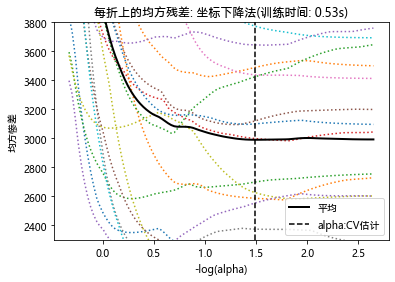



In [ ]:
# LassoLarsCV: 最小角度回归法

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=20).fit(X, y)
t_lasso_lars_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.cv_alphas_ + EPSILON)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='平均', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('均方惨差')
plt.title('每折上的均方残差: 最小角度回归法'
          '(训练时间: %.2fs)' % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

plt.show()

    Computing regularization path using the Lars lasso...


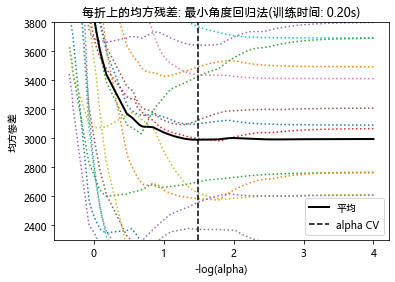